# <h1><center>*Predicting Home Prices*</center></h1>

# Goals:

 - Identify what drives home values
 - Build a model to best predict home values
 ___

# Imports

In [1]:
import pandas as pd
import numpy as np

import acquire as a
import prepare as p
import explore as e
import modeling as m

import seaborn as sns
import matplotlib.pyplot as plt 

from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt 

import warnings
warnings.filterwarnings("ignore")

---------------------------------------------------------------------------------------------------------------

# Acquire

 - Data acquired through Sequel Ace from the Codeup database.
 - Wrote a function in my acquire.py file that includes a sql query to extract the data
 - It contained 56,079 rows and 12 columns before cleaning
 - Each row represents a home in this zillow dataset
 - Each column represents a feature of the dataset 
 
 __________

# Prepare

 - Removed columns that were not useful, made a column
 - Checked for nulls in the data
 - Checked that column data types were appropriate
 - Renamed columns
 - Removed Outliers
 - Encoded variables that would promote useability for my models
 - Created dummy variables for categorical variables
 - Added dummy variables to dataset
 - Split data into train, validate and test (approx. 70/15/15)
 
 
 _____

# Data Dictionary


| Target Variable |     Definition     |
| :---------------: | :------------------: |
|      home_value      | price of the house |

| Feature  | Definition |
| :-------------: | :-------------: |
| year_built | The year the house was built  |
| lot_sqft | The square feet of the lot  |
| long | The longititude coordinates of the house |
| lat | The latitude coordinates of the house |
| transaction_month | The month of the transaction date |
| bathrooms | Number of bathrooms in the house | 
| bedrooms | Nummber of bedrooms in the house |
| fips | Code identifier for county |
| sqft | Square feet of the property|
| county | Name of the county the house is located |



_____

# A brief look at the data

In [2]:
# acquiring and cleaning the data
df = a.get_wine_data()
df = p.clean_wine_data(df)

# splitting data into train, validate, and test
train, validate, test = p.train_val_test(df)

In [3]:
#displaying all columns and getting first 5 rows
train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,type
2293,7.6,0.290,0.58,17.50,0.041,51.0,225.0,0.9997,3.16,0.66,9.5,6,white
731,8.9,0.875,0.13,3.45,0.088,4.0,14.0,0.9994,3.44,0.52,11.5,5,red
2958,6.5,0.190,0.32,1.40,0.040,31.0,132.0,0.9922,3.36,0.54,10.8,7,white
6396,5.7,0.330,0.32,1.40,0.043,28.0,93.0,0.9897,3.31,0.50,12.3,6,white
2652,9.4,0.290,0.55,2.20,0.050,17.0,119.0,0.9962,3.12,0.69,10.3,4,white


# A summary of the data

In [4]:
# a look at our column names, data types, and null counts
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4547 entries, 2293 to 4271
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         4547 non-null   float64
 1   volatile_acidity      4547 non-null   float64
 2   citric_acid           4547 non-null   float64
 3   residual_sugar        4547 non-null   float64
 4   chlorides             4547 non-null   float64
 5   free_sulfur_dioxide   4547 non-null   float64
 6   total_sulfur_dioxide  4547 non-null   float64
 7   density               4547 non-null   float64
 8   ph                    4547 non-null   float64
 9   sulphates             4547 non-null   float64
 10  alcohol               4547 non-null   float64
 11  quality               4547 non-null   int64  
 12  type                  4547 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 497.3+ KB


# Explore

### *1. Do red or white wines have a higher quality score?*

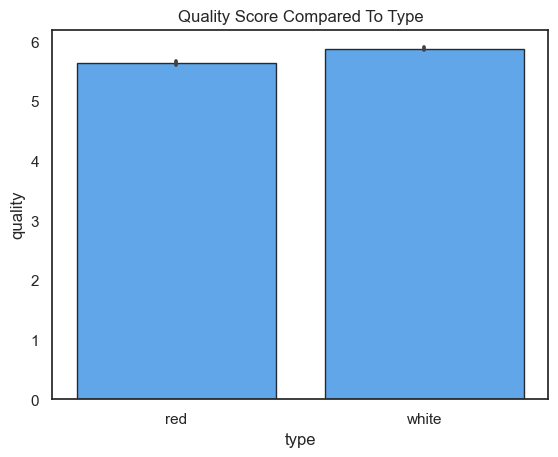

In [5]:
# a bar plot showing us type of wine compared to quality score
e.barplot(df, 'type', 'quality')

**Takeaways**

- From the bar chart there seems to be a little difference between quality in the different types of wine, but its unclear

**Ran a $chi^2$ test to evaluate if there is significance of dependency between  type and quality** <br>

$H_0$: Quality is not dependent on type of wine.

$H_a$: Quality is dependent on type of wine.

Confidence Interval 95% <br>
𝜶 = .05


In [6]:
e.chi_test('type', df)

We reject the null hypothesis.
chi² = 116.543
p = 8.66e-23


**Takeaways**

- After running a $chi^2$ test we reject the null hypothesis, meaning quality is dependent on the type of wine

_____

### *2. Does alcohol impact quality positively or negatively?*

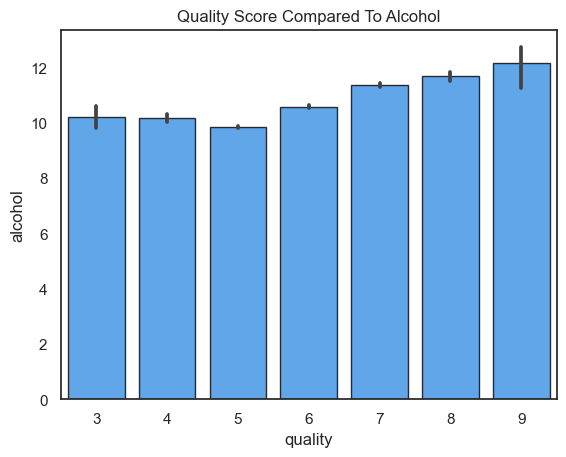

In [7]:
#a scatter plot showing us a relationship between lot sqft to home prices
e.barplot2(df, 'quality' ,'alcohol')

**Takeaways**

- It seems like quality of the wine increases as alcohol increases as well.


________

### *3. Does the month of the transaction affect the price of the home?*

In [8]:
# a bar plot showing us the transaction months to home prices
#e.plot_categorical_and_continuous_vars(df, 'transaction_month', 'home_value')

**Takeaways**

- It seems like September had the highest home price value followed by June.

**Ran a pearsonr test to evaluate if there is relationship between transaction month and house value** <br>

$H_0$: There is no relationship between home price and the month of the transaction<br>
$H_a$: There is a relationship between the month of the transaction of the home and the price

 - Confidence interval of 95%
 - Alpha is .05


**Takeaways**

- We reject the null hypothesis, meaning there is a relationship between transaction date and home value. Transaction date will be moved forward for modeling

_____

### *4. Are Orange County home values higher compared to Los Angeles and Ventura County home values?*


In [9]:
# a scatter plot using latitude and longitude to map out homes in their counties
# q4

**Takeaways**

- It seems like Orange County homes are more expensive than the other two counties

**Ran a one sample t test to evaluate if Oragne County Homes are more expensive than Los Angeles and Ventura** <br>

$H_0$: Orange County home values are <= Los Angeles and Ventura home values<br>
$H_a$: Orange County home values are > than Los Angeles and Ventura home values

 - Confidence interval of 95%
 - Alpha is .05


In [10]:
# calling a function from explore.py to run a one sample t test
#e.county_stats_test(train)

**The p-value is more than the Alpha. Therefore, we have strong support that Orange County homes are greater in value compared to Los Angeles and Ventura.**

----

# Exploration Summary

**- Bedrooms, bathrooms, lot sqft, transaction month, and county were found to be features that affect the home value**<br>
**- All features will be added for the modeling phase<br>**
**- County and transaction month seem to have the strongest influence.**
 
 ------

# Modeling 

- Goal is to minimize RMSE, so this will be my evaluation metric
- Ran 3 models including a Linear Regression , Tweedie, and a Polynomial 
- Before modeling scaled data and split
- We evaluated the models on train and validate data 
- The best performing model then was evaluated on test data subset

In [11]:
df = m.combined_df(df, 'alcohol', 'ph')

In [12]:
# splitting data into train, validate, and test
train, validate, test = p.train_val_test(df)

In [13]:
# wrote a function to scale my train, validate, and test data subsets
train_scaled, validate_scaled, test_scaled = m.mvp_scaled_data(train, validate, test)

In [14]:
# looking at one line of data in our scaled data
train_scaled.head(1)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,type,scaled_clusters
2293,0.31405,0.14,0.349398,0.259202,0.053156,0.173611,0.504608,0.242722,0.330709,0.247191,0.217391,6,white,0


In [15]:
# calling a function I wrote in my modeling.py to split my data in to X/y train, validate, test
X_train, y_train, X_validate,y_validate, X_test, y_test = m.splitting_subsets(train, train_scaled, validate_scaled, test_scaled)

In [16]:
# a look to 1st observation of our scaled, split, train subset
X_train.head(1)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,type_red,type_white,scaled_clusters_0,scaled_clusters_1,scaled_clusters_2,scaled_clusters_3
2293,0.31405,0.14,0.349398,0.259202,0.053156,0.173611,0.504608,0.242722,0.330709,0.247191,0.217391,0,1,1,0,0,0


In [17]:
# called my function that in my modeling.py to demostrate my 3 best models and the baseline
# this includes the train rmse, validate rmse, and their difference 

m.best_models(X_train, y_train, X_validate, y_validate)

,model,train_rmse,validate_rmse,difference
0,linear_poly,0.721184,0.782887,-0.061702
1,linear,0.732087,0.750386,-0.018299
2,tweedie,0.794486,0.809016,-0.014530
3,baseline,0.870897,0.870897,0.000000


### Modeling Summary & Evaluation 

**The best performing model is the linear model, so we tested the model with the test data**

In [18]:
# this is the best model and ran the test data on it
m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

,model,train_rmse,validate_rmse,difference,test_rmse
1,linear,0.732087,0.750386,-0.018299,0.789499


------

<div class="alert alert-info">
    <header>
    <h2>Conclusions:</h2>    
</header>    
<dt>
    
Home value predictions were used by minimizing RMSE within our models. County and transaction month have proven to be the most valuable, but there is still room for improvement.
<br>        
Best Model's performance:

- My best model reduced the root mean squared error by 82500 dollars compared to the baseline results.

- RMSE 82493.41 dollars on in-sample (train), RMSE 84100.76 dollars on out-of-sample data (validate) and RMSE of 80897.87 dollars on the test data.</dt>

<header>
    <h2>Recommendations:</h2>        
</header>      
<dl>
    
- I would recommend using counties and transaction months to build models to predict home values. 

- I would also recommend collecting more data about the homes. For example, crime rates in the county, average salary within neighborhoods, and school rankings.
 

<header>
    <h2> Next Steps:</h2>       
</header> 
</dl>
    
- I would add more columns/features from the database to see if there are better relationships to help predict price.

- Consider adding different hyperparameters to models for better results.  

</div>